# Assignment4 -- Calcium imaging analysis -- Solutions

In this notebook we will work on calcium imaging analysis, starting from simple visualizations, preprocessing steps and finaly some simple signal analysis of the extracted calcium traces. The final aim is to extract from  *1 photon microscopy* videos the calcium traces of multiple neurons and be able to make simple decoding analysis from the traces. For that we will use an already available open source software called **CaImAn**. Particularly we will use the algorithm called **CNMF-E** (standing for *Constrained Non-Negative Matrix factorization*) for extraction cell activity of 1-photon microscopy data. 

For this exercise we will need:

- CaImAn. Installationthrough conda-forge (August 2019) can be found here: [CaImAn](https://github.com/flatironinstitute/CaImAn/blob/master/docs/source/Installation.rst). Please install the Package-based process (no need for development mode).
- Numpy 
- Matplotlib
- Scipy
- Sklearn for simple trace analysis
- Jupyter lab or jupyter notebook

Remember to *conda activate caiman* environment before running the notebook.

You will find some of the required plotting function in the *auxiliary_functions.py* and *normalization_functions.py* files. You can complete the exercises by adding functions to that file or just by writting the code in a jupyter notebook cell.

The different exercises for this assigment are distributed along the notebook, there are a total of $10$ assignments, with some additional questions that are not mandatory.

In [1]:
##import python standard libraries
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle
import psutil
import logging
import os

##import caiman and caiman funcions that will be used
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF

##import auxiliary functions for plotting file
import auxiliary_functions


/home/melisa/anaconda3/envs/caiman/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


It it recomendable to have separate folders for the raw data and the multiple files that will be created, as especified in the **README**.

Here declare your work directory paths that will be used in the rest of the notebook (please change them to your ouw ones). 

In [2]:
data_dir = '/home/melisa/Documents/neuro_course/data/'           # define your data directory
figures_dir = '/home/melisa/Documents/neuro_course/figures/'     # define your results directory


## Videos and images

A genetically enconded calcium indicator is inyected (GCaMP) so a fluorescence signal is emited when there is change in calcium concentration. Influx and outflux of calcium molecules in cells are related to the generation of spikes, so in that sense fluorecence is related to firing rate of neurons. We can capture that fluorecence with a microscope. 

There are two main microscopy techniques for detecting calcium fluorecence, *1-photon*   (confocal microscopes use 1-photon microscopy technique) and *2-photon microscopy*, but nowadays there are trial for using even *3-photon* imaging. The use of one or the other imaging technique will depend on the specific scientific questions of the experimenter and the available resourses. 

On the one hand, miniendoscopes (small microscopes with 1-photon technology) are portable and can be use in freely moving animals, while (with the current technologies) 2-photon microscopy requires a laser setup where the animal need to be head fixed (and demands muchs higher experimental costs). On the other hand, excitation plane of 2-photon microscopy is much well define as tissue emited light intensity decays as 1/I^2 from the focal plane, while it decays slower with 1-photon microscopy. This last fact makes it harded to create an apropiate pre-processing algorithm to extract calcium fluctuaction (because background also includes activity from different cells in other focal planes).  

We will work on a fragment of a decoded video from **Inscopixs** miniscope (1-photon imaging). This videos have an original sampling rate of $20$Hz, but had been downsample to $10$Hz. The videos are $500$ frames lenght so the algoritms should be runnable in a personal laptop. In the data folder there are multiple examples of videos which will be used in later exercises for multitrial analysis as well as some already source extracted files.

First we will work with one complete video. The entire **FOV** (field of view) from the microscope is saved in file *calcium_video.tif*, while the file *calcium_video_trial_0.tif* has the cropped **ROI** (region of interest) we will work with.  

In [3]:
### Here we declara the name of the files we will be using verify it existance in the current directory.

input_tif_file_path_FOV = data_dir + 'raw/' + 'calcium_video.tif'   # define the path of the raw FOV movie
if not os.path.isfile(input_tif_file_path_FOV):                     # verify that the file exist
    logging.error('Calcium video file not found.')

input_tif_file_path = data_dir + 'raw/' + 'caiman_video_trial_0.tif'   # define the path of the raw ROI movie
if not os.path.isfile(input_tif_file_path):                            # verify that the file exist
    logging.error('Calcium video cropped file not found.')

In [7]:
###Here an additional window will open displaying a typical 1-photon calcium imaging video. 
###There you can see the multiple cells turning on and off as a light that is being emited. 

# videos visualization
FOV = cm.load(input_tif_file_path_FOV)           # load complete FOV

gain = 1.         #light intensity of video
magnification = 1 #size of display movie
fr = 20           #frequency of visualization (it is not sampling rate from the original movie)

FOV.play(gain = gain, magnification = magnification, fr = fr) #show video of calcium fluorecence


*If a video does not pop put from the previous cell, you can visualize it directly with VLC or any multimedia reprocucer using calcium_video.avi*

As can be seen from the original video, there are regions in the border that are not iluminated, so it make no sense to use them in the processing. Files called *caiman_video_trial_#.tif* are the ones corresponding to a cropped regions of the entire video. We will work with those, and here you can see to which region of the origina video it corresponds. 

FOV : = entire field of view of the microscope

ROI : = region of interest we will work with. It corresponds to the most iluminated area.

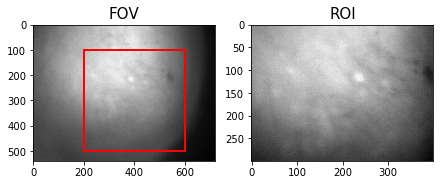

In [8]:
# image visualization
cropped_region_fig_path = figures_dir + 'FOV_calcium_video_1.png'       #path where the image will be saved

auxiliary_functions.plot_FOV(FOV_file = input_tif_file_path_FOV , ROI_file = input_tif_file_path, 
                             output_file = cropped_region_fig_path)

For any process that tries to separate neurons from background it is important to take into account that the statistics of regions with neurons will be remarkably different from the statistics of regions with no neurons. With  1-photon imaging this is diffuse because background also includes activity from neurons in other focal planes (as explained above). 

#### Exercise 0 : Image characteristics

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot. Plotting the temporal trace will allow us to see the calcium transient dinamic, if a pixel belonging to a neuron is selected. 

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are choosen from an active neuron, you will be able to see the calcium transcient dynamic. 

*Extra*  
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to differ a neuron from the background?

* If we can already see the calcium traces from the row data, why do we need to do a segmentation of the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces? 

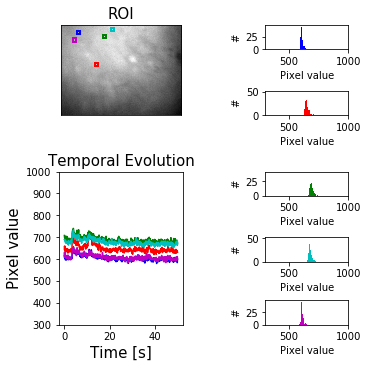

In [9]:
# temporal evolution visualization and statistics of pixels
temporal_pixel_evolution_fig_path = figures_dir + 'temporal_evolution_calcium_video_1.png'

auxiliary_functions.temporal_evolution(file_name = input_tif_file_path ,
                                       output_file_name = temporal_pixel_evolution_fig_path)

***Answer: Statistics from pixels that belong to neurons are significantly different that pixels that belong to background (or background plus neurons). The main difference will correspond to the mean value in time for the pixel value. Using the mean value to generate an image is normally use as an inicialitiacion to be able to detect in which regions neurons are located (summary image). 
Even if row traces contain lots of information about the calcium traces they not a clean calcium trace as they hace aditional noise. Also, roughly all pixels that correspond to the same neuron will show similar activation, and if not segmented properly they will induce spurious neural correlations in a further analysis.***

### Summary images : mean image, correlation image and PNR image

Summary images are simplification of the videos that gives information about the entire video statistics in one single frame. They are use for computing metrics about the video (quality of motion correction) or also, in the case of CNMF-E (the algorithm we will use), as seed inicialization for source extraction algorithm. 

The most used summary images are:

- **Mean image** : compute the temporal mean of the entire ROI and create one average image.
- **Correlation image**: for every pixel compute the correlation over time with it four (or more) nearest neightbors and compute the mean over that correlation value (this is the pixel value of each pixel in the correlation summary image). With this definition pixels corresponding to the same cell that has the same actitity and changes in luminosity will be more highly correlated while pixels belonging to the background will be less correlated (will see and example in further seccions).
- **Peak to Noise Ratio (PNR)**: computes te the peak to noise ratio pixel by pixel.

##### Exercise 1: video statistics

* Compute the mean and correlation summary images for *caiman_video_trial_0.tif*. You can use *mean* and *corrcoef* functions from *numpy* for that aim. 

Note: Correlation image can be computed taking *m* nearby pixels. At this instance use 4 nearest-neighbords for each pixel. When using CaImAn we will use 8 nearest-neightbords 

* Plot the resulting summary images and the difference between them (make sure they are defined in the same range of relative values), and plot all in the same range [0,1].
 
*Extra*

* The range of the mean summary image and the correlation image are different. Normalize the first one to the maximum pixel value to compare both of them. Which summary image gives a better understading of how to segment neurons? Now, if a summary image is the seed for a automatic detection algorith, which image do you think will be a better inicializer and why? 

In [10]:
original_movie = cm.load(input_tif_file_path)
mean_frame = np.mean(original_movie,axis = 0)
print(original_movie.shape)
correlation_image = np.zeros(mean_frame.shape)
for i in range(1,original_movie.shape[1]-1):
    for j in range(1,original_movie.shape[2]-1):
        corr1 = np.corrcoef(original_movie[:,i,j],original_movie[:,i-1,j])
        corr2 = np.corrcoef(original_movie[:,i,j],original_movie[:,i+1,j])
        corr3 = np.corrcoef(original_movie[:,i,j],original_movie[:,i,j-1])
        corr4 = np.corrcoef(original_movie[:,i,j],original_movie[:,i,j+1])
        correlation_image[i,j] = (corr1[0,1]+corr2[0,1]+corr3[0,1]+corr4[0,1])/4

(500, 300, 400)


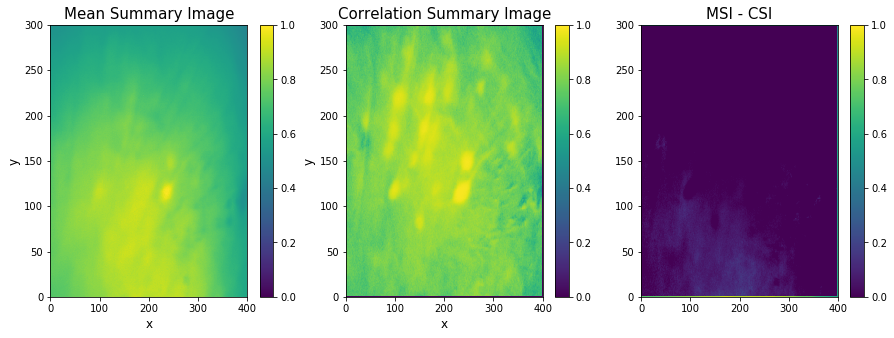

In [11]:
figure, axes = plt.subplots(1,3)

axes[0].set_xlabel('x', fontsize = 12)
axes[0].set_ylabel('y', fontsize = 12)
axes[0].set_title('Mean Summary Image', fontsize = 15)

axes[1].set_xlabel('x', fontsize = 12)
axes[1].set_ylabel('y', fontsize = 12)
axes[1].set_title('Correlation Summary Image', fontsize = 15)

axes[1].set_xlabel('x', fontsize = 12)
axes[1].set_ylabel('y', fontsize = 12)
axes[2].set_title('MSI - CSI', fontsize = 15)

mesh0 = axes[0].pcolormesh(mean_frame/np.max(mean_frame), cmap = 'viridis')
mesh1 = axes[1].pcolormesh(correlation_image, cmap = 'viridis')
mesh2 = axes[2].pcolormesh(mean_frame/np.max(mean_frame)-correlation_image, cmap = 'viridis')

vmin_corr = 0
vmax_corr = 1
mesh0.set_clim(vmin_corr,vmax_corr)
mesh1.set_clim(vmin_corr,vmax_corr)
mesh2.set_clim(vmin_corr,vmax_corr)


figure.colorbar(mesh0,ax=axes[0])
figure.colorbar(mesh1,ax=axes[1])
figure.colorbar(mesh2,ax=axes[2])

figure.set_size_inches(15,5)

***Answer: Within the same range of values, correlation images has a higher variability in nearby pixels that correspond to same neuron with the ones that belongs to the background, which makes this more suitable for a seed for a segmnetation algorithm.***

## Preprocessing calcium videos

Before running into extracting neural activity it is important to take into account that videos from alive animals has intrinsic motion (you can see that from the video dispayed before) that can correspond to respiration, microscopes movements or the movements from the animal itself. This means that it is necesary to correct the motion in multiple frames and align them to a common frame. The typical calcium imaging pre-processing pipeline consists of motion correction of the videos followed by source extraction.

### Motion correction

In this notebook we will use **NoRMCorre**, which is the motion correction algorithm that is implemented in the CaImAn pipeline as well. 

We will first perform a *rigid motion correction* and then a *non-rigid (piece-wise) motion correction* of multiple patches of the FOV (proposed in NoRMCorre). For rigid motion correction all frames are aligned to a template using a displacement vector. The displacement vector is computed by computing the maximum cross-correlation value between each frame and the template. PW-rigid (piece-wise-rigid) motion correction consists on spliting the FOV into overlapping patches and perform registration in each patch. Each patch is then splited again and for each sub-patch a displacement vector is computed. Final patch's motion correction is computed by using a smooth motion field created by all sub-patches displacement vectors. A good approach for a good motion correction would be to first run rigid motion correction to solve for all general 'big' displacements of the field of view and then run non-rigid motion correction for correcteness of local shifts (non-uniform displacements).

Motion correction requires a general set of parameters definition that are an input to the algorithm. 

The first step into correction motion is to high pass filter the images (smoothing borders): *gSig_filt* . The size of the filter will affect how smooth or sharp the borders of different parts of the image are define. Small filter size will result in multiple images that has lower pixel by pixel correlation values, while big filter size can oversmooth the image to the point where everything will be highly correlated. This is one paremeter to optimize when runnin motion correction and depends on the size in pixels of a typical neuron.

For rigid motion correlation the complete frame will be shift in a *xy* direction. This shift should be limited, as for example, there could be high cross-correlation between in one frame and the mean towards some direction because of highly correlated co-activated neurons that are 'highly' spatialy separated. The limitation for this is imposed by the  *max_shifts* parameter. Similar criteria applyes for non-rigid motion correction, where in this case the limitation is in number of pixels the patch can be shifted from the rigid version (*max_deviation_rigid*). 

For non-rigid motion correction size of patches and overlapping between different patches should be define, ie *strides* and *overlaps*.

For more information about motion correction algorithm see [Pnevmatikakis et al,2017](https://www.sciencedirect.com/science/article/pii/S0165027017302753) *NoRMCorre: An online algorithm for piecewise rigid motion correction of calcium imaging data*.


#### Example of motion correction 

First we will define all the parameters that are relevant to perform motion correction in a rigid and non-rigid manner, and will explore the results after a first step of rigid and pw-rigid motion correction.

After the example you will have to explore the effect on some of these parameters in the resulting motion corrected movie.


In [12]:
## parameters_motion_correction. We create them in a dictionary to prepare for caiman paramenters requirements

parameters_motion_correction = { 'pw_rigid': True,  # flag for performing piecewise-rigid motion correction (otherwise just rigid)
                                'save_movie_rig': True, # flag to say whether the rigig motion corrected movie is saved
                                'gSig_filt': (5, 5),     # size of high pass spatial filtering, used in 1p data
                                'max_shifts': (25, 25),  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
                                'niter_rig': 1 ,
                                'strides': (48, 48),     # create a new patch every x pixels for pw-rigid correction
                                'overlaps': (96, 96),    # overlap between pathes (size of patch strides+overlaps)
                                'upsample_factor_grid': 1,
                                'num_frames_split': 80,  # length in frames of each chunk of the movie (to be processed in parallel)
                                'max_deviation_rigid': 15, # maximum deviation allowed for patch with respect to rigid shifts
                                'shifts_opencv': True, 'use_cuda': False, 'nonneg_movie': True,
                                'border_nan': 'copy'}


# load tif movie as a caiman movie object
original_movie = cm.load(input_tif_file_path)
# Calculate movie minimum to subtract from movie (this is necesary for running motion correction)
min_mov = np.min(original_movie)
# Apply the parameters to the CaImAn algorithm. 
parameters_motion_correction['min_mov'] = min_mov
opts = params.CNMFParams(params_dict = parameters_motion_correction)

It is necesary to start a cluster to run the subsequent steps from the pipeline

In [13]:
n_processes = psutil.cpu_count()
cm.cluster.stop_server()
# Start a new cluster
c, dview, n_processes = cm.cluster.setup_cluster(backend='local',
                                                 n_processes=n_processes,
                                                single_thread=False)

Process ForkPoolWorker-7:
Process ForkPoolWorker-6:
Process ForkPoolWorker-1:
Process ForkPoolWorker-8:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/melisa/anaconda3/envs/caiman/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/melisa/anaconda3/envs/caiman/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/melisa/anaconda3/envs/caiman/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/melisa/anaconda3/envs/caiman/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/melisa/anaconda3/envs/caiman/lib/

Run motion correction algorithm in two steps: first perform *rigid motion correction* and them *pw-rigid motion correction*. 

The object *mc* will containg the motion correction movie and all the relevant information, for example *mc.x_shifts* contains information about the rigid shifts that were perform in the x axis of the image frame by frame (*mc.y_shifts for y-axis*). 

In [14]:
#create an object for motion correction
mc = MotionCorrect(input_tif_file_path, dview = dview, **opts.get_group('motion'))
# Perform rigid motion correction
mc.motion_correct_rigid(save_movie = parameters_motion_correction['save_movie_rig'], template = None)
m_rig = cm.load(mc.fname_tot_rig[0])
fname_tot_rig  = m_rig.save(data_dir + 'motion_corrected/' + 'calcium_video_1' +'_rig' + '.mmap',  order='C')         
os.remove(mc.fname_tot_rig[0]) #remove old version

#perform non-rigid motion correction
total_template_rig = mc.total_template_rig
mc.motion_correct_pwrigid(save_movie=True, template = total_template_rig)
fname_tot_els = mc.fname_tot_els[0]
m_els = cm.load(fname_tot_els)
fname_tot_els  = m_els.save(data_dir + 'motion_corrected/' + 'calcium_video_1' + '_els' + '.mmap',  order='C')
os.remove(mc.fname_tot_els[0])

##### Exercise 2: Rigid vs Non-Rigid motion correction


The objects *mc* contains information regarding the shifts produced by rigid and non-rigid motion corrections. For rigid motion correction you will find two vectors of size *500* frames corresponding to the shifts produced in each frame by rigid displacements. For non-rigid motion correction each atribute of the object contains multiple size *500* vectors corresponding to the shifts of all patches in *x* and *y* direction. 

 * Plot the shifts produced by rigid and pw-rigid motion correction frame by frame. In the case of pw-rigid plot the mean and std from multiple patches in each direction.
 * Compare rigid and no-rigid shifts statistics. Plot histogram for both and compute relevants parametes. 
 * Which algorithm produces bigger modifications? Which would you expect to produce better outputs respect to the quality of the motion corrected image and why?

Note: *use mc.shifts_rig, mc.x_shifts_els and mc.y_shifts_els*

Rigid motion correction x-mean: -0.1  std : 0.30000000000000004
Rigid motion correction y-mean: 0.0  std : 0.5
PW-rigid motion correction x-mean: 0.038845714285714296  std : 0.29626078947372
PW-rigid motion correction y-mean: -0.0865257142857143  std : 0.5893232046533186


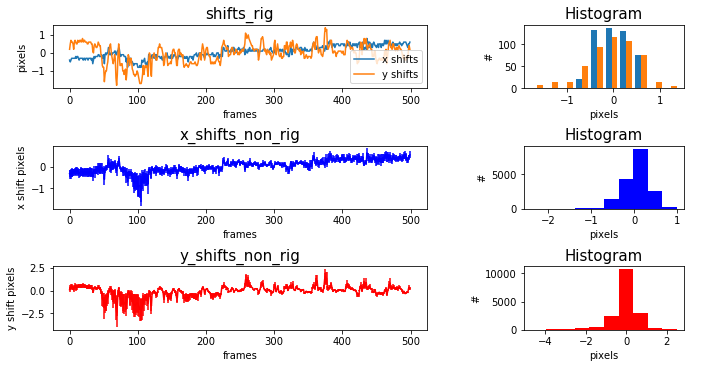

In [15]:
#%% visualize rigid and elastic shifts
figure = plt.figure(constrained_layout=True, figsize= (10,5))
gs = figure.add_gridspec(3, 12)

figure_ax0 = figure.add_subplot(gs[0, 0:7])
figure_ax0.set_title('shifts_rig', fontsize = 15)

figure_ax00 = figure.add_subplot(gs[0, 8:11])
figure_ax00.set_title('Histogram', fontsize = 15)

figure_ax0.plot(mc.shifts_rig)
figure_ax0.legend(['x shifts','y shifts'])
figure_ax0.set_xlabel('frames')
figure_ax0.set_ylabel('pixels')

figure_ax00.hist(np.array(mc.shifts_rig))
figure_ax00.set_xlabel('pixels')
figure_ax00.set_ylabel('#')


figure_ax1 = figure.add_subplot(gs[1, 0:7])
figure_ax1.set_title('x_shifts_non_rig', fontsize = 15)
figure_ax2 = figure.add_subplot(gs[1, 8:11])
figure_ax2.set_title('Histogram', fontsize = 15)

figure_ax1.errorbar(np.arange(0,len(mc.x_shifts_els)),np.mean(mc.x_shifts_els,1),np.std(mc.x_shifts_els,1),color='b')
figure_ax1.set_xlabel('frames')
figure_ax1.set_ylabel('x shift pixels')

figure_ax2.hist(np.array(mc.x_shifts_els).flatten(),color='b')
figure_ax2.set_xlabel('pixels')
figure_ax2.set_ylabel('#')

figure_ax3 = figure.add_subplot(gs[2, 0:7])
figure_ax3.set_title('y_shifts_non_rig', fontsize = 15)
figure_ax4 = figure.add_subplot(gs[2, 8:11])
figure_ax4.set_title('Histogram', fontsize = 15)

figure_ax3.errorbar(np.arange(0,len(mc.y_shifts_els)),np.mean(mc.y_shifts_els,1),np.std(mc.y_shifts_els,1),color='r')
figure_ax3.set_xlabel('frames')
figure_ax3.set_ylabel('y shift pixels')

figure_ax4.hist(np.array(mc.y_shifts_els).flatten(),color='r')
figure_ax4.set_xlabel('pixels')
figure_ax4.set_ylabel('#')

print('Rigid motion correction x-mean:',np.mean(mc.shifts_rig[0]), ' std :', np.std(mc.shifts_rig[0]))
print('Rigid motion correction y-mean:',np.mean(mc.shifts_rig[1]), ' std :', np.std(mc.shifts_rig[1]))


print('PW-rigid motion correction x-mean:',np.mean(np.mean(mc.x_shifts_els,1)), ' std :', np.std(np.mean(mc.x_shifts_els,1)))
print('PW-rigid motion correction y-mean:',np.mean(np.mean(mc.y_shifts_els,1)), ' std :', np.std(np.mean(mc.y_shifts_els,1)))


In [110]:
# play original video, rigid motion corrected and pw motion corrected
# concatenate the three movies along axes 2
gain = 1
magnification = 1
fr = 10
movies_chained = cm.concatenate([original_movie,m_rig,m_els],axis = 2).resize(1,1,.5).play(gain = gain, magnification = magnification, fr = fr)

#### Evaluation metrics

As proposed in [Pnevmatikakis et al. 2017](https://www.sciencedirect.com/science/article/pii/S0165027017302753). there are different measurements that can be used to evaluate the performance of the motion correction algorithm, for example the rigid vs pw results. 

A simple measure that is computed directly in the summary images (mean image or correlation image) is the crispness. This is done by computing the norm of the gradient field of the image at all pixels. 
If SI is the summary image then its crispness can be defined as 

$$C(SI) = ∥ | ∇SI | ∥_F $$


where $ ∇I $ denotes the gradient vector field of $I$ in all directions, $|·|$ denotes the entry-wise magnitude, and $ ∥·∥_F $ denotes the Frobenius norm. Lower values of crispness means higher intrinsic motion (the image is blurrer). Higher values of crispness means there are sharp transition borders, which translates into having a better define non-moved image.

There are other measures that can be use to quantify the quality of the motion that take into account the complete motion field of the video. For a matter of simplicity and computational capacity here we will implement crispness as a quality assesment measure for motion correction.

##### Exercise 3: quality assesment


Quality assesment by crispness is computed in a summary image that could be any of the ones previously mentioned.  
* Compute the mean and correlation image for the original movie, the rigid motion corrected and the pw-motion corrected. You can use your previously done function or use the method local correlations from caiman object. You can see documantion and caiman demostration for this. 
* Plot the different summary images for all the movies.
* Create a function that computes the crispness as define above and use it to compute quality measure in the mean and correlation summary images. For that, just remove the border in the computations. Compare the crispness result after motion correction with the original value for the correlation image.
* Defined as above, can cripsness be used directly to compare the motion quality of differnt videos with different image resolutions? what should be taken into account in order to compare them?

*Extra*: 
* Use caiman function to compute crispness in the correlation image.

Tip: use the atribute *local_correlation*s from original movie, m_rig and m_els.

In [17]:
### compute summary images

# mean summary image
original_movie_mean = np.mean(original_movie,axis = 0)
m_rig_mean = np.mean(m_rig,axis = 0)
m_els_mean = np.mean(m_els,axis = 0)

# correlation summary image

original_movie_corr = original_movie.local_correlations(eight_neighbours=True, swap_dim=False)
m_rig_corr = m_rig.local_correlations(eight_neighbours=True, swap_dim=False)
m_els_corr = m_rig.local_correlations(eight_neighbours=True, swap_dim=False)

In [18]:
def compute_crispness(image = None):
    
    ## complete here with crispness algorithm that uses the four-nearest neighbords to compute the gradient
    
    crispness = 0
    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            grad1 = np.abs(image[i,j]-image[i-1,j])
            grad2 = np.abs(image[i,j]-image[i+1,j])
            grad3 = np.abs(image[i,j]-image[i,j-1])
            grad4 = np.abs(image[i,j]-image[i,j+1])
            crispness = crispness + (grad1+grad2+grad3+grad4)/4
    #crispness = crispness / ((image.shape[0]-1)*(image.shape[1]-1))
    
    return crispness

In [19]:
### manually compute crispness for summary images using function compute crispness and print values
crispness_original_mean = compute_crispness(original_movie_mean)
print('Crispness Mean Original Movie: ', crispness_original_mean)
crispness_m_rig_mean = compute_crispness(m_rig_mean)
print('Crispness Mean Rigid MC: ', crispness_m_rig_mean)
crispness_m_els_mean = compute_crispness(m_els_mean)
print('Crispness Mean PW-rigid MC: ', crispness_m_els_mean)

crispness_original_corr = compute_crispness(original_movie_corr)
print('Crispness Corr Original Movie: ', crispness_original_corr)
crispness_m_rig_corr = compute_crispness(m_rig_corr)
print('Crispness Corr Rigid MC: ', crispness_m_rig_corr)
crispness_m_els_corr = compute_crispness(m_els_corr)
print('Crispness Corr PW-rigid MC: ', crispness_m_els_corr)

Crispness Mean Original Movie:  330633.1093673706
Crispness Mean Rigid MC:  201894.04096221924
Crispness Mean PW-rigid MC:  217335.16501617432
Crispness Corr Original Movie:  783.8400685707104
Crispness Corr Rigid MC:  959.0237092819048
Crispness Corr PW-rigid MC:  959.0237092819048


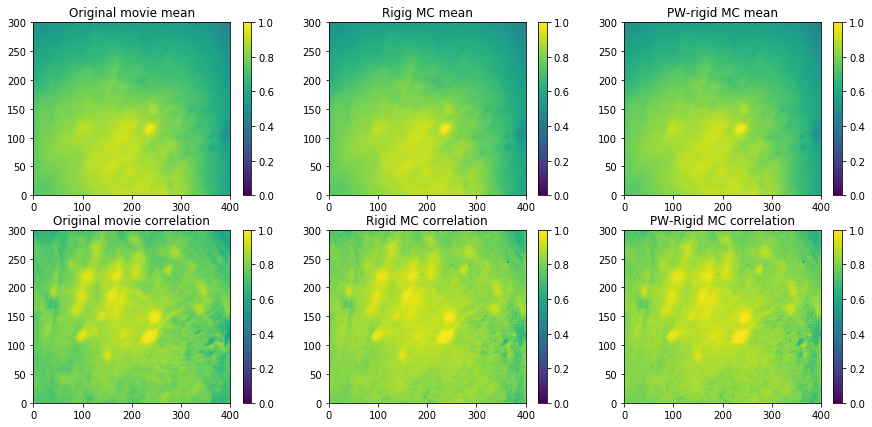

In [20]:
figure, axes = plt.subplots(2,3)
figure.set_size_inches(15,7)

mesh0 = axes[0,0].pcolormesh(original_movie_mean/np.max(original_movie_mean))
axes[0,0].set_title('Original movie mean')
mesh1 = axes[0,1].pcolormesh(m_rig_mean/np.max(m_rig_mean))
axes[0,1].set_title('Rigig MC mean')
mesh2 = axes[0,2].pcolormesh(m_els_mean/np.max(m_els_mean))
axes[0,2].set_title('PW-rigid MC mean')

mesh3 = axes[1,0].pcolormesh(original_movie_corr)
axes[1,0].set_title('Original movie correlation')
mesh4 = axes[1,1].pcolormesh(m_rig_corr)
axes[1,1].set_title('Rigid MC correlation')
mesh5= axes[1,2].pcolormesh(m_els_corr)
axes[1,2].set_title('PW-Rigid MC correlation')

vmin_corr = 0
vmax_corr = 1
mesh0.set_clim(vmin_corr,vmax_corr)
mesh1.set_clim(vmin_corr,vmax_corr)
mesh2.set_clim(vmin_corr,vmax_corr)
mesh3.set_clim(vmin_corr,vmax_corr)
mesh4.set_clim(vmin_corr,vmax_corr)
mesh5.set_clim(vmin_corr,vmax_corr)

figure.colorbar(mesh0,ax=axes[0,0])
figure.colorbar(mesh1,ax=axes[0,1])
figure.colorbar(mesh2,ax=axes[0,2])
figure.colorbar(mesh3,ax=axes[1,0])
figure.colorbar(mesh4,ax=axes[1,1])
figure.colorbar(mesh5,ax=axes[1,2])


*Extra* Now use the method *motion_correction.compute_metrics_motion_correction* from the object *cm* to compute the same values. 

The intend of this exercise is to familiarize with the CaImAn tool and not particularly relavant for understanding the methodology. 

In [74]:
# compute borders of motion corrected movie to exclud
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(np.int)
#%% compute borders to exclude
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els) # remove pixels in the boundaries
winsize = 100
swap_dim = False

tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    input_tif_file_path , final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    fname_tot_rig, final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    fname_tot_els, final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False)

In [75]:
# print crispness values
print('Crispness original: '+ str(int(crispness_orig)))
print('Crispness rigid: '+ str(int(crispness_rig)))
print('Crispness elastic: '+ str(int(crispness_els)))

Crispness original: 1037
Crispness rigid: 844
Crispness elastic: 863


#### Parameters selection

Output and quality assesment values of motion correction will be dependent on the selected paramenters. If crispness values after motion correction are not bigger than the original that could mean that the paramenters used for motion correction were not optimal and they deteriorated the image/ In the above example some parameters could not optimal for motion correction in this particular video. For the example we used one selected value of the filter, but the performance of the motion correction algorithm will be dependent on the quality of the image that comes out from that filter and how blurry that image is.

##### Exercise 4 : Motion correction parameters impact

One parameter that impacts motion correction performance is the size of the spatial filter that is applyed to the video.

* Use the following function from CaImAn and plot the result of different space filtering applyed to a single frame of the video:from caiman.motion_correction import high_pass_filter_space

* How will this filtering affect the measure of crispness?

* Acording to Pnevmatikakis et al, which other factors are relevant for pw-rigid motion correction? 

*Extra*

- Explore the impact of different parameters in the output of motion correction algorithm by measuring crispness in the correlation image of the final outcome. Particularly measure the effect of different spatial filter size by applying motion correction algorithm multiple times and computing the crispness of the output video. 

- Display all crispness values for rigid and not rigid motion correction and plot them agains gSig_filters values.

- If possible, show the impact of the crispness value that comes from changing other relevant paraments.

*Note1: The is no need to save all the motion corrected movies, just save the cripsness values.*

*Note2: gSig_filters is an optional range of posible values, but if your computer gets to slow in the computation reduce the range.*


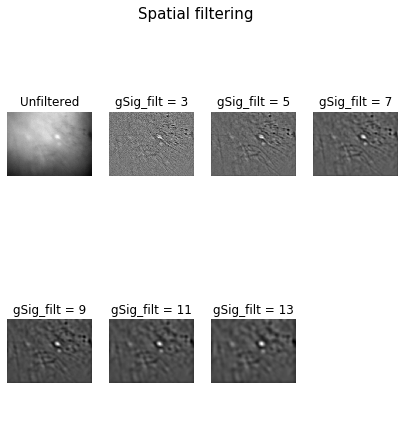

In [133]:
gSig_filters = 2*np.arange(0,6)+3
filters_output_fig_path = figures_dir + 'calcium_video_1' + '_filters.png'
auxiliary_functions.get_fig_gSig_filt_vals(file_name = input_tif_file_path ,
                                           gSig_filt_vals = gSig_filters, output_file = filters_output_fig_path )

In [18]:
crispness_rig_list = []
crispness_els_list = []

for gSig in gSig_filters:
    parameters_motion_correction = { 'pw_rigid': True,  # flag for performing piecewise-rigid motion correction (otherwise just rigid)
                                'save_movie_rig': True, # flag to say whether the rigig motion corrected movie is saved
                                'gSig_filt': (gSig,gSig), # size of high pass spatial filtering, used in 1p data
                                'max_shifts': (25, 25),  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
                                'niter_rig': 1 ,
                                'strides': (48, 48),     # create a new patch every x pixels for pw-rigid correction
                                'overlaps': (96, 96),    # overlap between pathes (size of patch strides+overlaps)
                                'upsample_factor_grid': 1,
                                'num_frames_split': 80,  # length in frames of each chunk of the movie (to be processed in parallel)
                                'max_deviation_rigid': 15, # maximum deviation allowed for patch with respect to rigid shifts
                                'shifts_opencv': True, 'use_cuda': False, 'nonneg_movie': True,
                                'border_nan': 'copy'}
    parameters_motion_correction['min_mov'] = min_mov
    opts = params.CNMFParams(params_dict = parameters_motion_correction)
   
    #create an object for motion correction
    mc = MotionCorrect(input_tif_file_path, dview = dview, **opts.get_group('motion'))
    # Perform rigid motion correction
    mc.motion_correct_rigid(save_movie = parameters_motion_correction['save_movie_rig'], template = None)
    m_rig = cm.load(mc.fname_tot_rig[0])   
    
    #perform non-rigid motion correction
    total_template_rig = mc.total_template_rig
    mc.motion_correct_pwrigid(save_movie=True, template = total_template_rig)
    m_els = cm.load(mc.fname_tot_els[0])

    tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
        mc.fname_tot_rig[0], final_size[0], final_size[1],
        swap_dim, winsize=winsize, play_flow=False)
    
    crispness_rig_list.append(crispness_rig)

    tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
        mc.fname_tot_els[0], final_size[0], final_size[1],
        swap_dim, winsize=winsize, play_flow=False)
    
    crispness_els_list.append(crispness_els)

[1028.5192, 844.2396, 812.4373, 807.1826, 811.63, 824.9479]
[1023.1414, 863.77783, 847.65814, 854.61, 863.5957, 873.815]


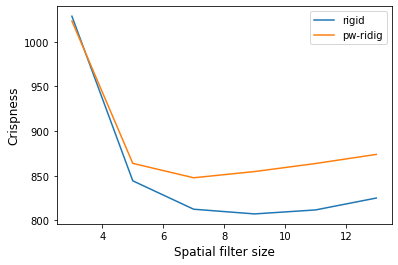

In [61]:
plt.plot(gSig_filters,crispness_rig_list)
plt.plot(gSig_filters,crispness_els_list)
plt.xlabel('Spatial filter size', fontsize = 12)
plt.ylabel('Crispness', fontsize = 12)
plt.legend(['rigid', 'pw-ridig'])
print(crispness_rig_list)
print(crispness_els_list)


### Source extraction

Original algorithms to perform source extraction from calcium videos were based on **PCA** and **ICA**. The disadvantage of appying this techniques directly is that they do not confine the sources to only one spatial region nor does provide good solution to deal with overlapping sources. As we are using CaImAn, in this notebook we will use a different technique called *Constrained Non-Negative Matrix Factorization* (**CNMF**). This technique (as non linear) solves the sparcity problem by adding multiple constrains to an optimation problem and also can deal better with overlapping sources. 

Matrix factorization part is based on the fact that a calcium imaging video can be  can be approximated as a product of two matrices: a spatial matrix (**A**) that encodes the location of each neuron in the optical field, and a temporal matrix (**C**) that characterizes the calcium concentration evolution of each neuron. This deconvolution can be constrained to the fact that spiking activity and the shape of each inferred neuron are as sparce as posible. 

The recorded video data can be represented by a matrix $Y∈R^{d×T}$, where $d$ is the number of pixels in the field of view and $T$ is the number of frames observed. Each neuron $i$ is characterized by its spatial *‘footprint’* vector $a_i ∈R^{d}$ characterizing the cell’s shape and location, and *‘calcium activity’* timeseries $c_i∈R^T$, modeling (up to a multiplicative and additive constant) cell i’s mean fluorescence signal at each frame. Here, both $a_i$ and $c_i$ are constrained to be nonnegative because of their physical interpretations. The background fluctuation is represented by a matrix $B∈R^{d×T}$. If the field of view contains a total number of K neurons, then the observed movie data is modeled as a superposition of all neurons’ spatiotemporal activity, plus time-varying background and additive noise:


$$ Y = \sum_{i=1..K} a_i . c_i^T + B + E = A C + B + E $$

where $A=[a_1,…,a_K]$ and $C=[c_1,…,c_K]^T$. The noise term $E∈R^{d×T}$ is modeled as Gaussian, $E(t)∼N(0,Σ)$ is a diagonal matrix, indicating that the noise is spatially and temporally uncorrelated.

Estimating the model parameters A,C in the model gives us all neurons’ spatial footprints and their denoised temporal activity. This can be achieved by minimizing the residual sum of squares (RSS), aka the Frobenius norm of the matrix Y−(AC+B),

$$ ∥Y−(AC+B)∥_F $$

while requiring the model variables A,C and B to follow the desired constraints, discussed above.



For more information about deconvolution methods see [Pnevmatikakis, et al. 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4881387/) *Simultaneous Denoising, Deconvolution, and Demixing of Calcium Imaging Data*.


More information about the background modeling for microendoscopic data can be found in [Pengcheng Zhou, et al. 2018](https://elifesciences.org/articles/28728) *Efficient and accurate extraction of in vivo calcium signals from microendoscopic video data*.


More information about **CaImAn** complete pipeline can be found in [Andrea Giovannucci, et al. 2019](https://elifesciences.org/articles/38173) *CaImAn an open source tool for scalable calcium imaging data analysis*


#### Summary images that are inicialitation for CNMF-E

CNMF-E algorithm takes as inicialization threshold values for the correlation and PNR images, so all regions that surpases those thresholds will be included in the model as neural footprint templates. 

In [21]:
# load motion corrected video
input_mmap_file_path = fname_tot_els 
Yr, dims, T = cm.load_memmap(input_mmap_file_path)         # load mmap file
images = Yr.T.reshape((T,) + dims, order='F' )

In [22]:
# compute correlation and pnr images 
gSig = 9
corr_image, pnr_image = cm.summary_images.correlation_pnr(images[::1], gSig=gSig,swap_dim=False)

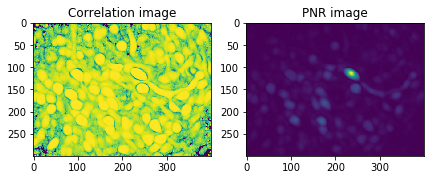

In [23]:
output_summary_images_fig_path = figures_dir + 'summary_images_calcium_video_1.png'
auxiliary_functions.summary_images(corr_image = corr_image, pnr_image = pnr_image, 
                                  output_path = output_summary_images_fig_path)

#### Example of source extraction

Here we will run an example on the video we have been working on for source extraction. First we will define some fixed parameters for this example and later we will explore the impact of those in the source extraction output (particularly the seeds for inicialization in CNMF-E). 

In [67]:
# create dictionary with source extraction parameters

parameters_source_extraction ={ 'fr': 10,               # movie frame rate
                               'decay_time': 0.1,       # length of a typical transient in seconds
                               'min_corr': 0.7,   # min peak value from correlation image
                               'min_pnr': 7,     # min peak to noise ration from PNR image
                                'p': 1,                # order of the autoregressive system 
                               'K': None,              # upper bound on number of components per patch, in general None
                               'gSig': (4, 4),         # gaussian width of a 2D gaussian kernel, which approximates a neuron
                               'gSiz': (17, 17),       # average diameter of a neuron, in general 4*gSig+1
                               'ring_size_factor': 1.4, # radius of ring is gSiz*ring_size_factor
                               'merge_thr': 0.7, 'rf': 60,
                               'stride': 30, 'tsub': 1, 'ssub': 2, 'p_tsub': 1, 'p_ssub': 2, 'low_rank_background': None,
                               'nb': 0, 'nb_patch': 0, 'ssub_B': 2, 'init_iter': 2,
                               'method_init': 'corr_pnr', 'method_deconvolution': 'oasis',
                               'update_background_components': True,
                               'center_psf': True, 'border_pix': 0, 'normalize_init': False,
                               'del_duplicates': True, 'only_init': True}
# create caiman parameters objects
opts = params.CNMFParams(params_dict=parameters_source_extraction)


In [68]:
# run source extraction (fit the model to the data)
cnmf_object = cnmf.CNMF(n_processes=n_processes, dview=dview, params=opts)
cnmf_object.fit(images)

In [16]:
# Save the cnmf object as a hdf5 file
output_cnmf_file_path = data_dir + 'source_extracted/' + 'calcium_video_0_cnmf.hdf5'
cnmf_object.save(output_cnmf_file_path)

The main outputs from CNMF are the matrix **A** containing the footprints and the matrix **C** containing the temporal calcium traces. Here we show the result of the A matrix by ploting the footprints on top on the correlation image and also ploting the temporal traces. 

*Note: Footprints are save in cnmf_object.estimates.A and temporal traces in cnmf_object.estimates.C *

Total number of componentes = 24


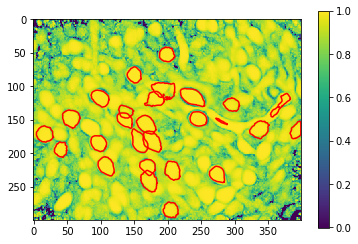

In [76]:
# display footprints in the ROI
figure, axes = plt.subplots(1)
pos = axes.imshow(corr_image)
coordinates = cm.utils.visualization.get_contours(cnmf_object.estimates.A, np.shape(corr_image), 0.2, 'max')
for c in coordinates:
    v = c['coordinates']
    c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                    np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
    axes.plot(*v.T, c='r')
figure.colorbar(pos, ax=axes)

print('Total number of componentes = ' + f'{cnmf_object.estimates.A.shape[1]}')

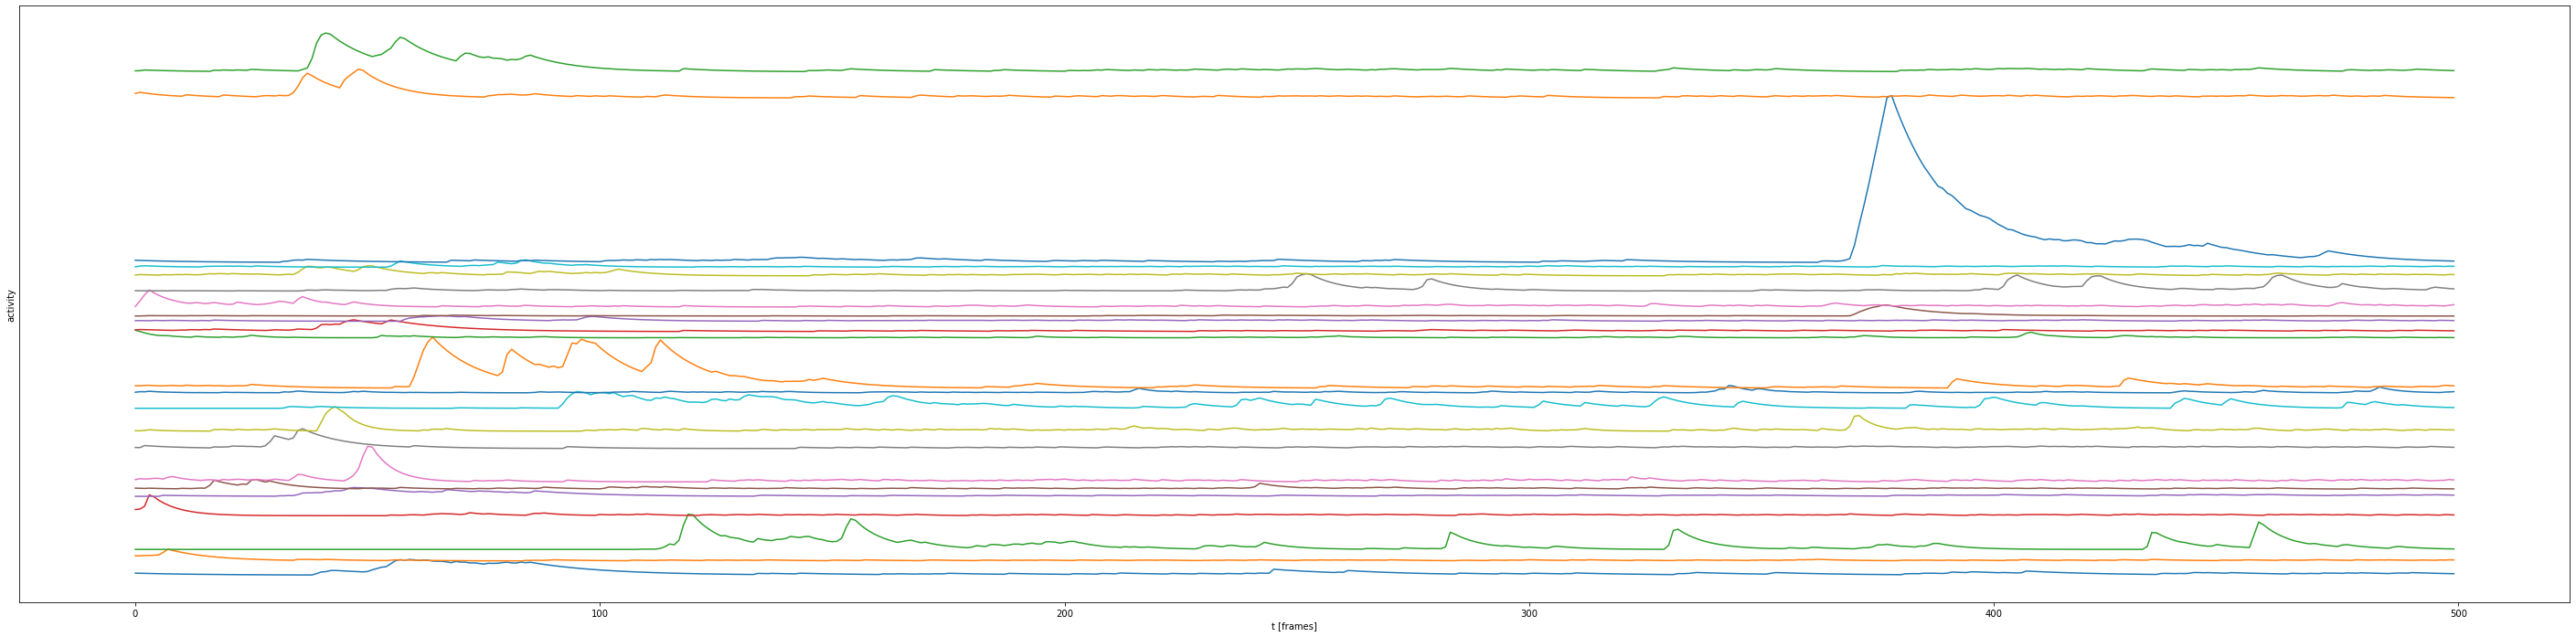

In [77]:
# plot temporal traces
figure, axes = plt.subplots(1)
C_0 = cnmf_object.estimates.C.copy()
C_0[1] += C_0[0].min()
for i in range(1, len(C_0)):
    C_0[i] += C_0[i].min() + C_0[:i].max()
    axes.plot(C_0[i])
axes.set_xlabel('t [frames]')
axes.set_yticks([])
axes.set_ylabel('activity')
figure.set_size_inches([50., .5 * len(C_0)])

#### Parameters selection


There are many paramenters involved in the source extraction algorithm but we will concentrate on the impact of two of them, *min_corr* and *min_pnr*, that are the seed for the 1p source extraction algorithm. 

Computation of source extraction is slow, and here we will run it multiple times, so ***be patient***.

You can change the *corr_values* and *pnr_values* range, but take into account that the lower those values are, the most permisive the conditions for select a region as a cell is. This will increase the number of cells that are detected but will also slow down the extraction algoritm. If you are having speed problems you can also try increasing the range of values of corr and pnr, which will result in a lower number of components detected.

##### Exercise 5: Source extraction parameters impact

* For a fixed minimum correlation value (ie 0.6) select a range of possible PNR minimun values and study the impact of those in the final source extraction output.

* For a fixed value of PNR (ie 6) select a range of minimum correlation valur and study the impact of those in the final source extraction output.

* How do these paramenters affect the spatial sparcity of the output? Which set of parameter selection procedes the higher number of neurons? Is maximal number of neurons always better? Why?  

* Generate a plot of number of neurons vs PNR (or min corr value) to show how these parameters affect the source extracted signals.

* Are the temporal traces affected by these parameters?

*Extra*

* For differten PNR and minimum correlation value plot the correlation image and the selected cells.

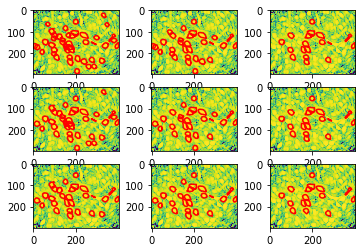

In [55]:
corr_values = [0.6, 0.7, 0.8]
pnr_values = [6,7,8]

num_of_components = []

figure, axes = plt.subplots(len(corr_values),len(pnr_values))
i=0
for corr in corr_values:
    j=0
    for pnr in pnr_values:
        parameters_source_extraction ={ 'fr': 10, 'decay_time': 0.1, 'min_corr': corr, 'min_pnr': pnr,
                                        'p': 1, 'K': None, 'gSig': (4, 4), 'gSiz': (17, 17), 'merge_thr': 0.7, 'rf': 60,
                                       'stride': 30, 'tsub': 1, 'ssub': 2, 'p_tsub': 1, 'p_ssub': 2, 'low_rank_background': None,
                                       'nb': 0, 'nb_patch': 0, 'ssub_B': 2, 'init_iter': 2, 'ring_size_factor': 1.4,
                                       'method_init': 'corr_pnr', 'method_deconvolution': 'oasis',
                                       'update_background_components': True,
                                       'center_psf': True, 'border_pix': 0, 'normalize_init': False,
                                       'del_duplicates': True, 'only_init': True}
        opts = params.CNMFParams(params_dict=parameters_source_extraction)
        cnmf_object = cnmf.CNMF(n_processes=n_processes, dview=dview, params=opts)
        cnmf_object.fit(images)
        num_of_components.append(cnmf_object.estimates.A.shape[0])
        axes[i,j].imshow(corr_image)
        coordinates = cm.utils.visualization.get_contours(cnmf_object.estimates.A, np.shape(corr_image), 0.2, 'max')
        for c in coordinates:
            v = c['coordinates']
            c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                            np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
            axes[i,j].plot(*v.T, c='r')
        j= j+1
    i=i+1
        

## Multisession registration

Experiments take lond periods of time and multiple trails or sessions that are not necesarily continuos in time. For calcium imaging there is one main restriction related to long recording periods that the photobleacing effect  (alteration of fluorophore molecule such that it permanently is unable to fluoresce). Because of this, periods of registration are normally alternated with resting periods. 

### Photobleaching effect

Because of prolonged exposure to light emision fluorecense saturates, producing a darker image, a phenomena known as phobleaching. You will be provided with multiple videos that were registered continously with small resting periods in the middle. 

##### Exercise 6: photobleaching effect

* Study the effect of photobleaching in the raw signal. For that aim use the videos called *'caiman_video_trial_'+ f'{trial}' +'.tif'* to create a new multisession video.
* Repeat exercise 0 in this new signal. How is bleaching reflected in the temporal evolution of a set of random pixels for these signals? 


*Extra*

* Study the differences in the statistics of pixel value in a trial by trial (histogram, mean and std).

Note: you may use *cm.concatenate()* method to create a new movie from a list of caiman objects.


In [44]:
# create a movie concatenating all segments on multiple trials
output_tif_file_concatenated = data_dir + 'raw/' + 'movie_concatenated.tif'
movie_list = []
corr_trials = []
pnr_trials = []
for trial in [0,1,2,3]:
    input_tif_file_path = data_dir + 'raw/' + 'caiman_video_trial_'+ f'{trial}' +'.tif'   
    if not os.path.isfile(input_tif_file_path):
        logging.error('File not found.')
    movie = cm.load(input_tif_file_path)
    movie_list.append(movie)
    
concatenated_movie = cm.concatenate(movie_list,axis = 0)
concatenated_movie.save(output_tif_file_concatenated)

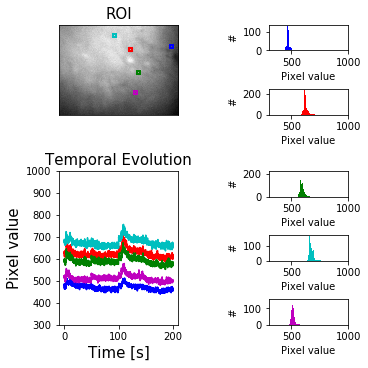

In [29]:
# temporal evolution visualization and statistics of pixels with multiple trials
temporal_pixel_evolution_photobleaching_fig_path = figures_dir + 'temporal_evolution_photobleaching.png'
auxiliary_functions.temporal_evolution(file_name = output_tif_file_concatenated,
                                       output_file_name = temporal_pixel_evolution_photobleaching_fig_path)

### Registration.

The next problem is that ideally one would like to analyze the evolution of the activity of one single cell over the entire experiment. One solution could be to use the concatenated movies as produced in the previos step and run an entire source extraction algorithm over that new video. That approch would be an easy solution to deal with tracking the same neurons, nevertheless it has some disadvantages. For example, because of bleaching the signals are non stationary, and the quality of them deteriorates over time ( a fact that is not included in the model we are currently using for source extraction). The other disadvantage is the resources that are required to perform source extraction in a longer video (principaly RAM memory). 

One solution to this problem is to perform a trial by trial source extraction, and then match the different components in multiple sessions that belong to the same cell. This procedure is called registration and uses the footprints of the extracted cells to perform a matching. There are different ways to perform registration, for example in [Sheintuch, et al. 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5670033/): *Tracking the Same Neurons across Multiple Days in Ca2+ Imaging Data*. In this case, we will use the algorithm proposed in the CaImAn software that is based in the *Hungarian Matching Algorithm*. 

#### Example

In the *'data/source_extracted/'* directory you will find multiple *.hdf5* files corresponding to a group of different sessions that were recording in the same mouse. This files were produced following the steps above, the only difference might be in the selection of motion correction or source extraction paramenters. 

One step that is important before registration is that all videos should be aligned. In this particulared case we have used the motion correction rutine in the concatenated file (produced as in the previous step) and use as a templete the first session. After that the video was redivided into the original time-session to produce different source extracted files that are given in this directory.

We will first try and example with two sessions and you will run the rest for more sessions and create the apropiate new temporal traces.

In [35]:
### import registration and normalization functions
from caiman.base.rois import register_multisession
import normalization_functions as normalization

In [36]:
# create a list with the files path that are going to be registered (this are the extracted files)
source_extracted_files_list = [data_dir + 'source_extracted/' + 'calcium_video_1_cnmf.hdf5', 
                          data_dir + 'source_extracted/' + 'calcium_video_2_cnmf.hdf5']
# create a list with the files path containing the different correlation image (summary image)
correlation_files_list = [data_dir + 'source_extracted/' + 'calcium_video_1_corr.npy', 
                          data_dir + 'source_extracted/' + 'calcium_video_2_corr.npy']

In [37]:
## multiple list created to append the relevant information for the registration and creation of a unique time trace
A_components_list = []  ## list for contour matrix on multiple trials
FOV_size = []  ## list for the cn filter dim (to verify it is always the same dims)
#C_traces_list = []  ## list with traces for each trial
for i in range(len(source_extracted_files_list)):
    cnm = load_CNMF(source_extracted_files_list[i])
    cn_filter = np.load(correlation_files_list[i])
    FOV_size.append(cn_filter.shape)
    A_components_list.append(cnm.estimates.A[:, cnm.estimates.idx_components])
    #raw_normed, cnm_normed, res_normed, s_normed, noise_levels =  normalization.normalize_traces(cnm.estimates.C,
    #                                                                                             cnm.estimates.YrA,cnm.estimates.S,1,offset_method="denoised_floor")
    #C_traces_list.append(cnm_normed)

In [46]:
# define parameters for the hungarian matching algorithm and run multisession registrations
thresh_cost = 0.9
max_dist = 15
spatial_union, assignments, match = register_multisession(A=A_components_list, dims=FOV_size[0], thresh_cost= thresh_cost, max_dist=max_dist)

print('Number of cells video 1 = ' + f'{A_components_list[0].shape[1]}')
print('Number of cells video 2 = ' + f'{A_components_list[1].shape[1]}')
print('Number of cells in spatial union = ' + f'{spatial_union.shape[1]}')

/home/melisa/anaconda3/envs/caiman/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Number of cells video 1 = 61
Number of cells video 2 = 36
Number of cells in spatial union = 81


##### Exercise 7.

For visualization of the original cells in each video and the overlap we can plot the correlation image for each video with their footprints and the spatial union. Here you can see that some neurons are active in both trials, while some are only actitive in one single trial. Spatial union represents all cells that were active in one or in both of them.

Create a figure as describe above. For spatial union you can use one of the two correlation images.

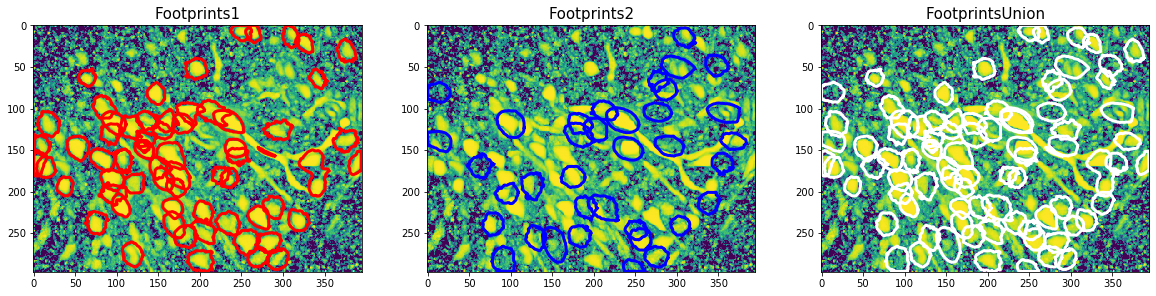

In [65]:
# display footprints in the ROI for video 1, 2 and overlap
figure, axes = plt.subplots(1,3)
corr_image_1 = np.load(correlation_files_list[0])
axes[0].imshow(corr_image_1)
coordinates = cm.utils.visualization.get_contours(A_components_list[0], np.shape(corr_image_1), 0.2, 'max')
for c in coordinates:
    v = c['coordinates']
    c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                    np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
    axes[0].plot(*v.T, c='r', linewidth = 3)
axes[0].set_title('Footprints1', fontsize = 15)
    
corr_image_2 = np.load(correlation_files_list[1])
axes[1].imshow(corr_image_1)
coordinates = cm.utils.visualization.get_contours(A_components_list[1], np.shape(corr_image_1), 0.2, 'max')
for c in coordinates:
    v = c['coordinates']
    c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                    np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
    axes[1].plot(*v.T, c='b', linewidth = 3)
axes[1].set_title('Footprints2', fontsize = 15) 

axes[2].imshow(corr_image_1)
coordinates = cm.utils.visualization.get_contours(spatial_union, np.shape(corr_image_1), 0.2, 'max')
for c in coordinates:
    v = c['coordinates']
    c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                    np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
    axes[2].plot(*v.T, c='w', linewidth = 3)
axes[2].set_title('FootprintsUnion', fontsize = 15)

figure.set_size_inches([20,20])

##### Exercise 8.

Use the multiple files provided in *'/raw/source_extracted/'* directory and create the new calcium trace for all time for each detected neuron after running registration. If posible use at least 5 files. 

Originaly we propose that registration method would be better than just doing an alignment and run the entire algorithm in one single video. One reason, as explained before, is the underling model. But, this does not solved the fact that each session have different baseline level, ans different signal to noise ratio. Because of that, before doing a concatenation of temporal calcium traces it is required to do a normalization of them, preferably taking into account signal to noise ratio variability. 

Use the rutines provided in normalization_functions file (from [zbarry](https://gist.github.com/zbarry)) before applying the concatenation for temporal traces. 

*Note: If plotting multiple traces of concatenated files is not posible, just select a few of them.*

In [70]:
# create a list with the files path that are going to be registered (this are the extracted files)
source_extracted_files_list = [data_dir + 'source_extracted/' + 'calcium_video_1_cnmf.hdf5', 
                               data_dir + 'source_extracted/' + 'calcium_video_2_cnmf.hdf5',
                               data_dir + 'source_extracted/' + 'calcium_video_3_cnmf.hdf5',
                               data_dir + 'source_extracted/' + 'calcium_video_4_cnmf.hdf5',
                               data_dir + 'source_extracted/' + 'calcium_video_5_cnmf.hdf5']
# create a list with the files path containing the different correlation image (summary image)
correlation_files_list = [data_dir + 'source_extracted/' + 'calcium_video_1_corr.npy', 
                          data_dir + 'source_extracted/' + 'calcium_video_2_corr.npy',
                          data_dir + 'source_extracted/' + 'calcium_video_3_corr.npy',
                          data_dir + 'source_extracted/' + 'calcium_video_4_corr.npy',
                          data_dir + 'source_extracted/' + 'calcium_video_5_corr.npy']

## multiple list created to append the relevant information for the registration and creation of a unique time trace
A_components_list = []  ## list for contour matrix on multiple trials
FOV_size = []  ## list for the cn filter dim (to verify it is always the same dims)
C_traces_list = []  ## list with traces for each trial
total_C_size = 0
for i in range(len(source_extracted_files_list)):
    cnm = load_CNMF(source_extracted_files_list[i])
    cn_filter = np.load(correlation_files_list[i])
    FOV_size.append(cn_filter.shape)
    A_components_list.append(cnm.estimates.A[:, cnm.estimates.idx_components])
    raw_normed, cnm_normed, res_normed, s_normed, noise_levels =  normalization.normalize_traces(cnm.estimates.C,
                                                                                                 cnm.estimates.YrA,cnm.estimates.S,1,offset_method="denoised_floor")
    C_traces_list.append(cnm_normed)
    total_C_size = total_C_size + cnm_normed.shape[1]

# define parameters for the hungarian matching algorithm and run multisession registrations
thresh_cost = 0.9
max_dist = 15
spatial_union, assignments, match = register_multisession(A=A_components_list, dims=FOV_size[0], thresh_cost= thresh_cost, max_dist=max_dist)

/home/melisa/anaconda3/envs/caiman/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/melisa/anaconda3/envs/caiman/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/melisa/anaconda3/envs/caiman/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/melisa/anaconda3/envs/caiman/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(115, 2500)
(115, 5)


In [126]:
traces = np.zeros((spatial_union.shape[0], total_C_size))
for i in range(spatial_union.shape[1]):
    time = 0
    for j in range(assignments.shape[1]):
        if math.isnan(assignments[i, j]) == False:
            traces[i][time : time + 500] = C_traces_list[j][int(assignments[i, j]),:]
        time = time + 500

Text(0, 0.5, 'activity')

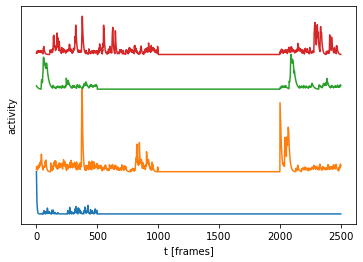

In [127]:
# plot temporal traces
figure, axes = plt.subplots(1)
C_0 = traces.copy()
C_0[1] += C_0[0].min()
for i in range(1, 5):
    C_0[i] += C_0[i].min() + C_0[:i].max()
    axes.plot(C_0[i])
axes.set_xlabel('t [frames]')
axes.set_yticks([])
axes.set_ylabel('activity')

## Analysis

For multiple sessions, source extraction can be run separatelly and a registration step is followed as was explained and done before. In directory */data/traces/* you will find a file called *traces_example.npy* where there are calcium traces corresponding to $42$ sessions that were registered all together following the previously described steps. The $42$ sessions are alternating between two behavioural conditions **A** and **B**. From some individual neurons it is already posible to see condition specificity responses. To do a simple analysis on the *population level* we will train a *support vector machine* (**SVM**) classifier to distinguish between these two conditions. 


Load traces file and temporal alignment information (timeline)

In [128]:
### load traces corresponding to registration of 42 trials, from 
traces_example_file_path = data_dir + 'traces/' + 'traces_example.npy'
traces = np.load(traces_example_file_path)
print('Number of neurons = ' + f'{traces.shape[0]}')
print('Number of temporal frames = ' + f'{traces.shape[1]}')

### load timeline concatenation information (this refers to the aligning concatenation time points)
timeline_file_path = data_dir + 'traces/' + 'traces_timeline.pkl'
timeline_file = open(timeline_file_path, 'rb')
timeline_info = pickle.load(timeline_file)

timeline_1 = np.zeros(len(timeline_info) + 1)
for i in range(len(timeline_info)):
    timeline_1[i] = timeline_info[i][1]
timeline_1[len(timeline_info)] = traces.shape[1]


Number of neurons = 262
Number of temporal frames = 130631


Here we show the behaviour of on neurons in the two different conditions (one condition is marked in light blue).

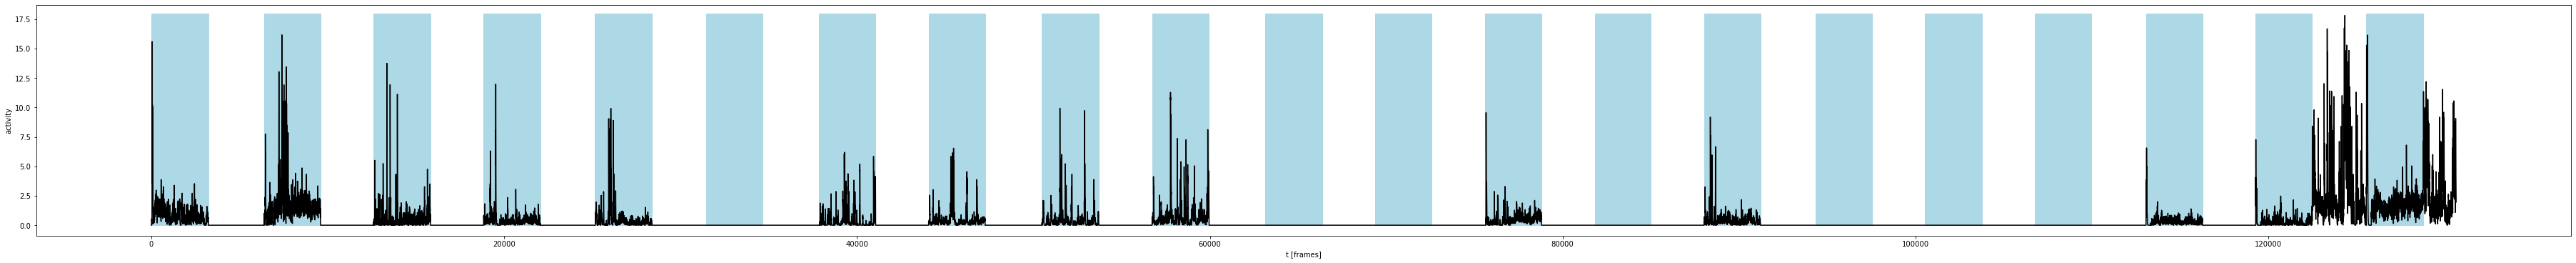

In [130]:
### plot one example of temporal traces after concatenation
cell_number = 1
figure = plt.figure(constrained_layout=True)
gs = figure.add_gridspec(1, 1)
figure_ax1 = figure.add_subplot(gs[0, 0])
figure_ax1.plot(traces[cell_number], color = 'k')
for i in range(0,len(timeline_1)-1,2):
    [x_, _x, y_, _y] = [0,18,timeline_1[i], timeline_1[i+1]]
    rect = Rectangle((y_, x_), _y - y_, _x - x_, fill=True, color='lightblue')
    figure_ax1.add_patch(rect)
figure_ax1.set_xlabel('t [frames]')
figure_ax1.set_ylabel('activity')
figure.set_size_inches([50., 5])

Text(0, 0.5, 'cell #')

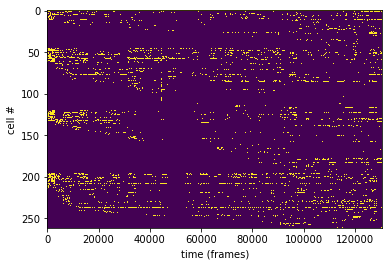

In [280]:
# represent neural activity matrix as a binary matrix
threshold = 1
binary_traces = np.zeros(traces.shape)
for i in range(traces.shape[0]):
    position = np.where(traces[i,:]>threshold)
    binary_traces[i,position] = 1
plt.imshow(binary_traces, cmap = 'viridis', aspect='auto')
plt.xlabel('time (frames)')
plt.ylabel('cell #')

##### Excersice 9. 

Train a binary classifier to separate the two conditions using svm from sklearn library. For that aim, you may follow the next steps:

- Resample temporal data by avaraging timepoints every re_sf frames. We recommend to use arround 500 frames, but yuo can try how this impacts the accuracy of the classifier. And, use a binarized version of this by selecting an adecuate threshold for the mean (as shown before).

- Create the accurate labels for this two condicions in the resample timeline.

- Separate training and testing data set by selecting randomly N temporal frames and evaluate the result in the rest of the temporal frames. Take into account that as the labels are half and half if you select point uniformly, the dataset will be balanced enough. Also N should not be smaller that the number of neurons that you use.

- Use a subset of neurons from the original traces file. 

- Evaluate the accuracy and plot the original vector condition (labels) and the tested one (resulted labels from svm).


(262, 261)


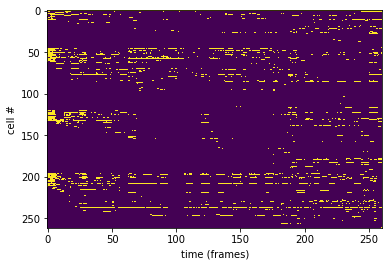

In [312]:
# import svm from sklearn library (see documentation)
from sklearn import svm
import scipy

neural_activity = traces
re_sf = 500 #resampling value
reshape_neural_activity = np.reshape(neural_activity[:, :int(int(neural_activity.shape[1] / re_sf) * re_sf)],
                                         (neural_activity.shape[0], int(neural_activity.shape[1] / re_sf), re_sf))
resample_neural_activity = np.mean(reshape_neural_activity, axis=2)

print(resample_neural_activity.shape)


### create condition and resample condition labels
labels = np.ones((traces.shape[1],1))
for i in range(0,len(timeline_1)-1,2):
    labels[int(timeline_1[i]):int(timeline_1[i+1])] = 0

reshape_labels = np.reshape(labels[:int(int(labels.shape[0]/re_sf)*re_sf)],(int(labels.shape[0]/re_sf),re_sf))
resample_labels = np.reshape(scipy.stats.mode(reshape_labels,axis=1)[0],reshape_labels.shape[0])


# represent neural activity matrix as a binary matrix
threshold = 1
binary_traces = np.zeros(resample_neural_activity.shape)
for i in range(resample_neural_activity.shape[0]):
    position = np.where(resample_neural_activity[i,:]>threshold)
    binary_traces[i,position] = 1
    
plt.imshow(binary_traces, cmap = 'viridis', aspect='auto')
plt.xlabel('time (frames)')
plt.ylabel('cell #')


resample_neural_activity = binary_traces

In [345]:
# separate training and testing data
all_data_id = list(np.arange(0,resample_neural_activity.shape[1]))

#select temporal points for traning
training_temporal_points = []
while len(training_temporal_points) < 150:
    temp = np.random.randint(0,resample_neural_activity.shape[1])
    if temp not in training_temporal_points:
        training_temporal_points.append(temp)
        
#create temporal points for testing
testing_temporal_points = []
for i in range(resample_neural_activity.shape[1]):
    if all_data_id[i] not in training_temporal_points:
        testing_temporal_points.append(all_data_id[i])
        
training_data_set = resample_neural_activity[:70,training_temporal_points]
testing_data_set = resample_neural_activity[:70,testing_temporal_points]

training_labels = resample_labels[training_temporal_points]
testing_labels = resample_labels[testing_temporal_points]

print('Number of training points = '+f'{len(training_temporal_points)}')
print('Training points with condition A = ' + f'{sum(training_labels)}')
print('Number of testing points = ' + f'{len(testing_temporal_points)}')

Number of training points = 150
Training points with condition A = 70.0
Number of testing points = 111


In [346]:
clf = svm.SVC()
clf.fit(training_data_set.T, training_labels.T)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [347]:
svm_prediction = clf.predict(testing_data_set.T)

In [348]:
overlap = 0
for i in range(len(svm_prediction)):
    if svm_prediction[i] == testing_labels[i]:
        overlap = overlap + 1
overlap = overlap / len(svm_prediction)
print(overlap)

0.8198198198198198


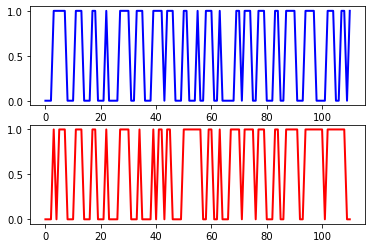

In [349]:
figure, axes = plt.subplots(2,1)
axes[0].plot(testing_labels, color = 'b', linewidth = 2)
axes[1].plot(svm_prediction, color = 'r', linewidth = 2)